# Matrix Factorization Using Neural Network(Demonstration)

## Import libraries

In [22]:
import pandas as pd
import numpy as np
import warnings
from keras.models import Model
from keras.layers import Input, Dot, Flatten
from keras.layers.embeddings import Embedding
from sklearn.utils import shuffle
from keras.callbacks import TensorBoard
from keras.regularizers import l2
from sklearn.metrics import mean_absolute_error
import warnings
import keras
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## Load the rating data

In [2]:
#load the rating data
ratingsHeader = ["UserID", "MovieID", "Rating", "Timestamp"]
ratingsDF = pd.read_table('Raw Data/ratings.dat',sep = '::', names = ratingsHeader, engine = "python")
ratingsDF

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


## Data Processing

In [3]:
#generate the continued userID and movieID for neural network
ratingsDF['userId']= ratingsDF.UserID.astype('category').cat.codes.values   
ratingsDF['movieId'] = ratingsDF.MovieID.astype('category').cat.codes.values
ratingsDF

,UserID,MovieID,Rating,Timestamp,userId,movieId
0,1,1193,5,978300760,0,1104
1,1,661,3,978302109,0,639
2,1,914,3,978301968,0,853
3,1,3408,4,978300275,0,3177
4,1,2355,5,978824291,0,2162
...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,6039,1019
1000205,6040,1094,5,956704887,6039,1022
1000206,6040,562,5,956704746,6039,548
1000207,6040,1096,4,956715648,6039,1024


## K - Fold Cross Validation

* shuffle the dataframe
* split the data into K folds
* split the trainData(K-1) and testData(1) for K times
* return the trainDataList and the testDataList

In [4]:
#split the data
def splitData(df, folds = 5, shu = True, randomState = None):
    trainDFList = []
    testDFList = []
    #shuffle the dataframe
    df = shuffle(df, random_state = randomState)
    #split the data into K folds
    nums = df.shape[0]
    length = int(nums / folds)
    dfList = []
    dfList.append(df[0:length])
    for i in range(1,folds - 1):
        dfList.append(df[i*length: (i + 1) * length])
    dfList.append(df[(folds - 1) * length :])
    #split the trainData and test Data
    for i in range(folds):
        testDF = dfList[i]
        tempList = []
        for j in range(folds):
            if(j != i):
                tempList.append(j)
        trainDF = dfList[tempList[0]]
        for j in range(1,folds - 1):
            trainDF = pd.concat([trainDF, dfList[tempList[j]]])
        trainDFList.append(trainDF)
        testDFList.append(testDF)
    #return the trainDataList and the testDataList
    return trainDFList, testDFList

In [5]:
#split the data
trainRatingDFList, testRatingDFList = splitData(ratingsDF, folds = 5, shu = True, randomState = 1)

## Load the rating data

In [6]:
#load the train rating data
trainRatingDF = trainRatingDFList[0]
X_train = [trainRatingDF.userId.values, trainRatingDF.movieId.values]
Y_train = trainRatingDF.Rating.values.astype(float)

In [7]:
#load the test rating data
testRatingDF = testRatingDFList[0]
X_test = [testRatingDF.userId.values, testRatingDF.movieId.values]
Y_test = testRatingDF.Rating.values.astype(float)

## Matrix Factorization Model Using Neural Network

### Structure of Neural Network

* UserInputLayer, MovieInputLayer
* UserEmbeddingLayer, MovieEmbeddingLayer
* UserFlattenLayer, MovieFlattenLayer
* OutputLayer(rating value)

### Detail of Model
* Optimizer : Adam
* Loss Function : Mean Absolute Error
* Epoch: 25

In [9]:
# Matrix Factorization Model Using Neural Network
def MatrixFactorizationModel(numUsers, numMovies, numFactors):
    #userLayer
    userInput = Input(shape = [1], name = "userInput")
    userEmbedding = Embedding(numUsers, numFactors, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6), name = "userEmbedding")(userInput)
    userFlatten = Flatten(name = "userFlatten")(userEmbedding)
    #movieLayer
    movieInput = Input(shape= [1], name = "movieInput")
    movieEmbedding = Embedding(numMovies, numFactors, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6), name = "movieEmbedding")(movieInput)
    movieFlatten = Flatten(name = "movieFlatten")(movieEmbedding)
    # Just like in the case of matrix factorization, we take product of user and movie embeddings.
    # This is trained to be equal to actual rating.
    #outputLayer
    rating = Dot(name = "OutputLayer", axes=1)([userFlatten, movieFlatten])
    MFModel = Model(inputs = [userInput, movieInput], outputs = rating)
    #optimizer
    opt = keras.optimizers.Adam()
    #loss function
    loss = keras.losses.MAE
    MFModel.compile(optimizer = opt, loss = loss)
    return MFModel

### Create the model

In [13]:
#create the model
numUsers = len(ratingsDF.UserID.unique())
numMovies = len(ratingsDF.MovieID.unique())
numFactors = 7
MFModel = MatrixFactorizationModel(numUsers, numMovies, numFactors)
MFModel.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
userInput (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
movieInput (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
userEmbedding (Embedding)       (None, 1, 7)         42280       userInput[0][0]                  
__________________________________________________________________________________________________
movieEmbedding (Embedding)      (None, 1, 7)         25942       movieInput[0][0]                 
____________________________________________________________________________________________

### Train the model

In [15]:
#train the model
history = MFModel.fit(x=X_train, y=Y_train, batch_size = 64, epochs=25, verbose=2,validation_data=(X_test, Y_test))

Train on 800168 samples, validate on 200041 samples
Epoch 1/25
 - 27s - loss: 0.8392 - val_loss: 0.7778
Epoch 2/25
 - 26s - loss: 0.7664 - val_loss: 0.7672
Epoch 3/25
 - 26s - loss: 0.7617 - val_loss: 0.7652
Epoch 4/25
 - 24s - loss: 0.7598 - val_loss: 0.7635
Epoch 5/25
 - 26s - loss: 0.7573 - val_loss: 0.7605
Epoch 6/25
 - 27s - loss: 0.7520 - val_loss: 0.7547
Epoch 7/25
 - 21s - loss: 0.7437 - val_loss: 0.7469
Epoch 8/25
 - 27s - loss: 0.7351 - val_loss: 0.7422
Epoch 9/25
 - 27s - loss: 0.7274 - val_loss: 0.7392
Epoch 10/25
 - 27s - loss: 0.7210 - val_loss: 0.7357
Epoch 11/25
 - 28s - loss: 0.7153 - val_loss: 0.7318
Epoch 12/25
 - 28s - loss: 0.7097 - val_loss: 0.7307
Epoch 13/25
 - 28s - loss: 0.7046 - val_loss: 0.7291
Epoch 14/25
 - 28s - loss: 0.7000 - val_loss: 0.7271
Epoch 15/25
 - 28s - loss: 0.6958 - val_loss: 0.7264
Epoch 16/25
 - 28s - loss: 0.6923 - val_loss: 0.7256
Epoch 17/25
 - 27s - loss: 0.6893 - val_loss: 0.7253
Epoch 18/25
 - 28s - loss: 0.6865 - val_loss: 0.7255
Epo

### Predict the rating values and Evaluate the performance of model

In [19]:
#predict the rating values and evaluate the performance of model
P_test = MFModel.predict(X_test)
mean_absolute_error(P_test, Y_test)

0.6890678408165672

## Plot the validation loss of Matrix Factorization Using Neural Network

Text(0.5,1,'The Validation Loss of Matrix Factorization Using Neural Network')

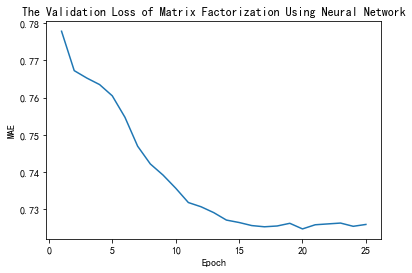

In [28]:
X = range(1, 26)
Y = history.history['val_loss']
plt.plot(X, Y)
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("The Validation Loss of Matrix Factorization Using Neural Network")